In [2]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from model import ode_y, ode_y_parallel
from simulation import simulation
from utilities import find_nearest_value, compute_derivatives
from solver import false_transient_one_iteration_python
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [16]:
# Intensity parameter
epsilon = 1. # .25 or 1.

r1 = -54.1669
if epsilon == .25:
    r0 = -4.3830
elif epsilon == 1.:
    r0 = -1.0957

# Robustness parameters
ξ_w = 100000.
ξ_p = 5.
ξ_a = 1./100

damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}

# Model parameters
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_bar_upper = 2.0
y_bar_lower = 1.7

# Grid setting
ϵ = 1.
y_step = .02
y_grid_long = np.linspace(0., 4., int(4/y_step) + 1)
y_grid_short = np.linspace(0., y_bar_upper , int(2/y_step) + 1)
y_grid_tilde = np.linspace(y_bar_lower, y_bar_upper-y_step, int((y_bar_upper-y_bar_lower)/y_step))

In [7]:
# Parallelly solve ODE
model_args_low = []
model_args_high = []
model_args_extreme = []

model_paras_low = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[0], y_jump)

for y_jump in y_grid_tilde:
    model_paras_high = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[1], y_jump)
    model_paras_extreme = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[2], y_jump)
    model_args_high.append((y_grid_long, model_paras_high, None, ϵ, 1e-8, 5000, False))
    model_args_extreme.append((y_grid_long, model_paras_extreme, None, ϵ, 1e-8, 5000, False))

print('----- Solving low damage model -----')
model_low = ode_y(y_grid_long, model_paras_low, None, ϵ, 1e-8, 5000, False)
print('----- Solving high damage models -----')
model_high_list = ode_y_parallel(model_args_high)
print('----- Solving extreme damage models -----')
model_extreme_list = ode_y_parallel(model_args_extreme)

----- Solving low damage model -----
Converged. Total iteration 5000: LHS Error: 2.696741196572816e-05; RHS Error 8.034055397260209e-05
----- Solving high damage models -----
----- Solving extreme damage models -----


In [13]:
# Prepare ϕ_m
ϕ_m = np.zeros((3, len(y_grid_short)))
y_bar_lower_loc = find_nearest_value(y_grid_short, y_bar_lower)
for i in range(len(y_grid_tilde)):
    ϕ_m[0, y_bar_lower_loc+i] = model_low['v0'][y_bar_lower_loc+i]
    ϕ_m[1, y_bar_lower_loc+i] = model_high_list[i]['v0'][y_bar_lower_loc+i]
    ϕ_m[2, y_bar_lower_loc+i] = model_extreme_list[i]['v0'][y_bar_lower_loc+i]

In [31]:
y_bar_upper_loc = find_nearest_value(y_grid_long, y_bar_upper)
temp_1 = model_low['v0'][:y_bar_upper_loc+1]
temp_2 = model_high_list[-1]['v0'][:y_bar_upper_loc+1]
temp_3 = model_extreme_list[-1]['v0'][:y_bar_upper_loc+1]
v_guess = np.average(np.array([temp_1, temp_2, temp_3]), weights=πd_o, axis=0)

In [34]:
def ode_y_jump_intensity_approach(y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8,
                                     max_iter=10_000, print_all=True):
    η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_i, πd_o, r0, r1, epsilon = model_paras
    Δ_y = y_grid[1] - y_grid[0]

    if v0 is None:
        v0 = -η*(y_grid+y_grid**2)

    d_Λ = γ_1 + γ_2*y_grid
    dd_Λ = γ_2

    πd = np.ones((len(πd_o), len(y_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd

    πc = np.ones((len(πc_o), len(y_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    intensity = r0 * (np.exp(r1 / 2. * (y_grid-y_bar_lower)**2) - 1.) * (y_grid >= y_bar_lower)\
                + 0 * (y_grid < y_bar_lower)

    e_tilde = 0.
    
    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        e_tilde_old = e_tilde

        v0_dy = compute_derivatives(v0, 1, Δ_y, central_diff=False)
        v0_dyy = compute_derivatives(v0, 2, Δ_y)

        G = v0_dy + (η-1)/δ*d_Λ

        if σ_y == 0:
            e_tilde = -η/(G*np.sum(πc*θ, axis=0))
        else:
            temp = σ_y**2*(v0_dyy+(η-1.)/δ*dd_Λ-G**2/ξ_1m)
            root = np.sum(πc*θ, axis=0)**2*G**2 - 4*η*temp
            root[root<0] = 0.
            e_tilde = (-G*np.sum(πc*θ, axis=0) - np.sqrt(root)) / (2*temp)
        
        e_tilde[e_tilde<=0] = 1e-16
        e_tilde = e_tilde *.5 + e_tilde_old*.5

        log_πc_ratio = -G*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16        
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

        g = np.exp(1./ξ_2m*(v0-ϕ_i))

        A = np.ones_like(y_grid)*(-δ)
        B = e_tilde * np.sum(πc*θ, axis=0)
        C = .5 * σ_y**2 * e_tilde**2
        D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
            + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
            - ξ_2m * intensity * (np.sum(πd_o * np.exp(-1./ξ_2m*ϕ_i), axis=0) - np.exp(-1./ξ_2m * v0)) \
                / np.exp(-1./ξ_2m * v0)

        v0 = false_transient_one_iteration_python(A, B, C, D, v0, ε, Δ_y, (0, 0), (False, False))

        rhs_error = A*v0 + B*v0_dy + C*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    h = -(v0_dy+(η-1)/δ*d_Λ)*e_tilde*σ_y/ξ_1m

    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))     
    res = {'v0': v0,
           'v0_dy': v0_dy,
           'v0_dyy': v0_dyy,
           'e_tilde': e_tilde,
           'y_grid': y_grid,
           'πc': πc,
           'g': g,
           'h': h,
           'θ': θ[:, 0],
           'σ_y': σ_y}
    return res

In [38]:
model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_m, πd_o, r0, r1, epsilon)
model_res = ode_y_jump_intensity_approach(y_grid_short, model_paras=model_paras, v0=v_guess, ϵ=.5,
                                          tol=1e-8, max_iter=10_000, print_all=True)

Iteration 1: LHS Error: 1.1960661759900433; RHS Error 1.1692832310816872
Iteration 2: LHS Error: 0.5264584644180867; RHS Error 0.5310100241487578
Iteration 3: LHS Error: 0.3653093551725095; RHS Error 0.3707570875680355
Iteration 4: LHS Error: 0.2805914661126898; RHS Error 0.2869586705048146
Iteration 5: LHS Error: 0.2292940635452334; RHS Error 0.2347672904470871
Iteration 6: LHS Error: 0.19299283341216023; RHS Error 0.20048799076691026
Iteration 7: LHS Error: 0.17058367172074984; RHS Error 0.1765861905384327
Iteration 8: LHS Error: 0.15194701961943413; RHS Error 0.15953015709341511
Iteration 9: LHS Error: 0.13518970523721308; RHS Error 0.14420447112469176
Iteration 10: LHS Error: 0.125802370319271; RHS Error 0.13070452287797257
Iteration 11: LHS Error: 0.11732301279940849; RHS Error 0.12350772912819849
Iteration 12: LHS Error: 0.10927457886793235; RHS Error 0.11668287522411872
Iteration 13: LHS Error: 0.10161937559224743; RHS Error 0.1102154394303549
Iteration 14: LHS Error: 0.09431998

Iteration 147: LHS Error: 0.017076668805342976; RHS Error 0.056002040141567615
Iteration 148: LHS Error: 0.016955208561571844; RHS Error 0.05600200630639389
Iteration 149: LHS Error: 0.016823119900737815; RHS Error 0.056001971613620666
Iteration 150: LHS Error: 0.016679980165982045; RHS Error 0.05600193604596678
Iteration 151: LHS Error: 0.016570046677476746; RHS Error 0.056001899594742874
Iteration 152: LHS Error: 0.016462898327673336; RHS Error 0.05600186225945385
Iteration 153: LHS Error: 0.01634612008798353; RHS Error 0.05600182404738
Iteration 154: LHS Error: 0.016219319424108036; RHS Error 0.05600178497317503
Iteration 155: LHS Error: 0.016082106592003598; RHS Error 0.05600174505843971
Iteration 156: LHS Error: 0.015983767492068424; RHS Error 0.056001704331330046
Iteration 157: LHS Error: 0.01587932373415768; RHS Error 0.056001662826151315
Iteration 158: LHS Error: 0.015765726845668127; RHS Error 0.05600162058297314
Iteration 159: LHS Error: 0.01564261331488037; RHS Error 0.05600

Iteration 296: LHS Error: 0.006502340390817984; RHS Error 0.055992294288171214
Iteration 297: LHS Error: 0.006464458042696464; RHS Error 0.05599248130849538
Iteration 298: LHS Error: 0.00642658643713645; RHS Error 0.05599166176874307
Iteration 299: LHS Error: 0.0063875224544105436; RHS Error 0.055991002621447614
Iteration 300: LHS Error: 0.0063509458759778425; RHS Error 0.055990609027429014
Iteration 301: LHS Error: 0.006312211843073179; RHS Error 0.05599154129168242
Iteration 302: LHS Error: 0.006275936922905068; RHS Error 0.055991587543199946
Iteration 303: LHS Error: 0.0062387290322627464; RHS Error 0.05599102925792364
Iteration 304: LHS Error: 0.006201631870936808; RHS Error 0.05599035585463735
Iteration 305: LHS Error: 0.006165831823418344; RHS Error 0.055989832010642934
Iteration 306: LHS Error: 0.006128095658325172; RHS Error 0.05598953583122636
Iteration 307: LHS Error: 0.006093578653111109; RHS Error 0.05598945274739958
Iteration 308: LHS Error: 0.006057066572002334; RHS Error

Iteration 449: LHS Error: 0.00020662145013083943; RHS Error 0.0560006304666643
Iteration 450: LHS Error: 0.00019548294492821583; RHS Error 0.05600088936929128
Iteration 451: LHS Error: 0.00018489432454238397; RHS Error 0.05600102126259857
Iteration 452: LHS Error: 0.00017483247452432238; RHS Error 0.05600107834037647
Iteration 453: LHS Error: 0.00016527455891157672; RHS Error 0.056001096163757515
Iteration 454: LHS Error: 0.00015619839824765336; RHS Error 0.056001094939509256
Iteration 455: LHS Error: 0.00014758256947011716; RHS Error 0.05600108506108201
Iteration 456: LHS Error: 0.00013940640855558684; RHS Error 0.056001071598366176
Iteration 457: LHS Error: 0.00013164999037229563; RHS Error 0.05600105696537163
Iteration 458: LHS Error: 0.00012429410888792347; RHS Error 0.05600104229199894
Iteration 459: LHS Error: 0.00011732026107225124; RHS Error 0.056001028084726116
Iteration 460: LHS Error: 0.00011071063318723873; RHS Error 0.056001014543177796
Iteration 461: LHS Error: 0.00010444

Iteration 598: LHS Error: 3.06760359336522e-07; RHS Error 0.056000770410198505
Iteration 599: LHS Error: 3.04796956562825e-07; RHS Error 0.05600077040409607
Iteration 600: LHS Error: 3.0281709051394046e-07; RHS Error 0.05600077039835381
Iteration 601: LHS Error: 3.007165991775196e-07; RHS Error 0.05600077039296554
Iteration 602: LHS Error: 2.988662259895136e-07; RHS Error 0.05600077038792138
Iteration 603: LHS Error: 2.9687436597924943e-07; RHS Error 0.05600077038321474
Iteration 604: LHS Error: 2.949179220834708e-07; RHS Error 0.05600077037884017
Iteration 605: LHS Error: 2.9304812354524756e-07; RHS Error 0.05600077037479147
Iteration 606: LHS Error: 2.9104247634137437e-07; RHS Error 0.056000770371060604
Iteration 607: LHS Error: 2.892265893450485e-07; RHS Error 0.05600077036764074
Iteration 608: LHS Error: 2.8733600387909064e-07; RHS Error 0.056000770364529016
Iteration 609: LHS Error: 2.8541801988524185e-07; RHS Error 0.05600077036171812
Iteration 610: LHS Error: 2.8363597159852816e

Iteration 743: LHS Error: 5.676983860780638e-08; RHS Error 0.05600077060929546
Iteration 744: LHS Error: 5.5362592732421945e-08; RHS Error 0.056000770609054853
Iteration 745: LHS Error: 5.398067415285368e-08; RHS Error 0.05600077060880676
Iteration 746: LHS Error: 5.262394431326811e-08; RHS Error 0.056000770608547606
Iteration 747: LHS Error: 5.1292262881474926e-08; RHS Error 0.056000770608279654
Iteration 748: LHS Error: 4.998546820900174e-08; RHS Error 0.05600077060800225
Iteration 749: LHS Error: 4.8703391541948804e-08; RHS Error 0.05600077060771757
Iteration 750: LHS Error: 4.744584813920483e-08; RHS Error 0.05600077060742743
Iteration 751: LHS Error: 4.621264970694483e-08; RHS Error 0.05600077060712938
Iteration 752: LHS Error: 4.500359374048912e-08; RHS Error 0.05600077060682563
Iteration 753: LHS Error: 4.38184635243033e-08; RHS Error 0.05600077060651752
Iteration 754: LHS Error: 4.2657042342852947e-08; RHS Error 0.05600077060620437
Iteration 755: LHS Error: 4.151909216432159e-0

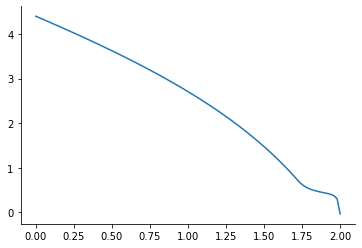

In [40]:
plt.plot(y_grid_short, model_res['v0'])